In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'DIA'  # emerging markets
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_dow.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(6663, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1998-01-20,77.81250,78.843750,77.406250,78.812500,44.873077,3.803838,1.012851,0.987708,0.990880
1998-01-21,78.09375,78.375000,77.281250,77.843750,44.321510,3.791470,0.996799,0.991569,0.991570
1998-01-22,77.18750,77.859375,76.937500,77.187500,43.947826,3.783003,1.000000,0.997571,1.004049
1998-01-23,77.50000,77.750000,76.312500,77.000000,43.841087,3.780571,0.993548,1.004058,1.004870
1998-01-26,77.37500,77.671875,76.937500,77.312500,44.019001,3.784621,0.999192,1.011723,0.997575
1998-01-27,77.12500,78.562500,77.078125,78.218750,44.535015,3.796276,1.014182,1.011586,1.001998
1998-01-28,78.37500,79.234375,78.218750,79.125000,45.050976,3.807795,1.009569,1.003554,0.999210
1998-01-29,79.06250,80.250000,78.890625,79.406250,45.211094,3.811342,1.004348,0.997837,1.006690
1998-01-30,79.93750,79.937500,78.968750,79.234375,45.113289,3.809177,0.991204,1.022480,1.017551


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
1998-01-20     78.843750
1998-01-21     78.375000
1998-01-22     77.859375
1998-01-23     77.750000
1998-01-26     77.671875
                 ...    
2024-07-08    396.730011
2024-07-09    395.040009
2024-07-10    397.459991
2024-07-11    398.890015
2024-07-12    402.690002
Name: high, Length: 6663, dtype: float64

In [6]:
SIM_START = pd.to_datetime('1998-01-20')  # first day of legit open/close values
SIM_START

Timestamp('1998-01-20 00:00:00')

In [7]:
len(df.index >= SIM_START)

6663

In [47]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']), #'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [37]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [48]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

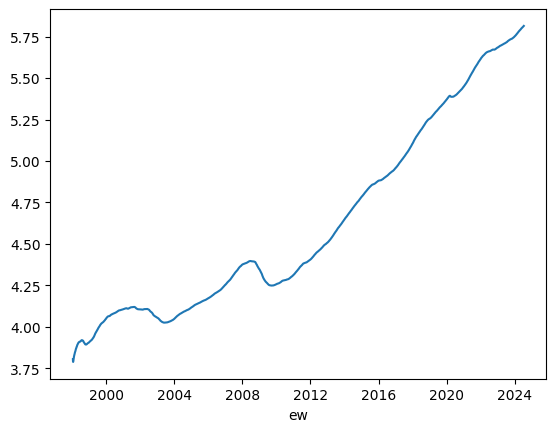

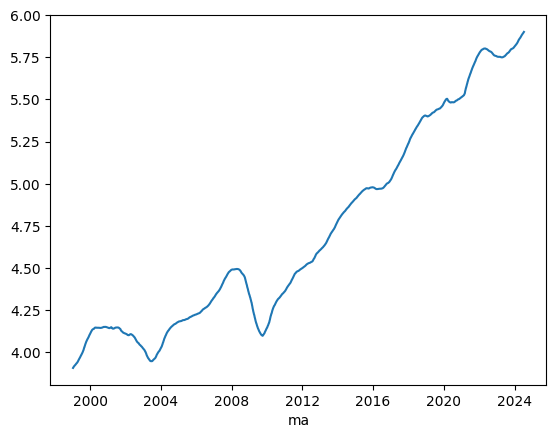

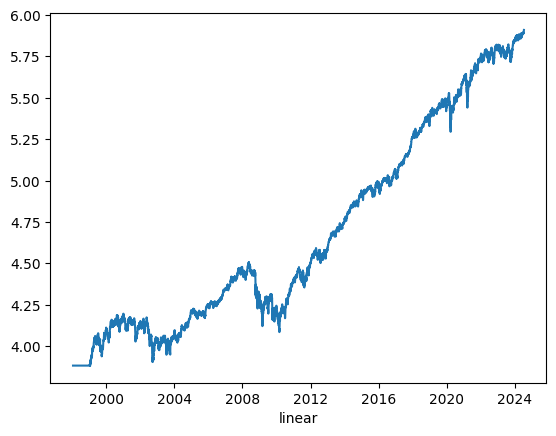

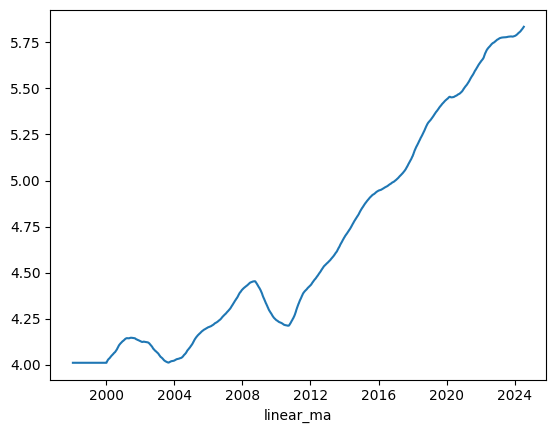

In [49]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [50]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [51]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [52]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [53]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [54]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [57]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params# = None, None

Do nothing res: 8.921162322386886
Round 1: 1.83354207783096
New best: 1.83354207783096
{'time_param': 47, 'method': 'ew', 't': 0.5509191365389573, 'k': 0.21446104540409006, 'as_q': False, 'transform_f': 'bounded_curve'}


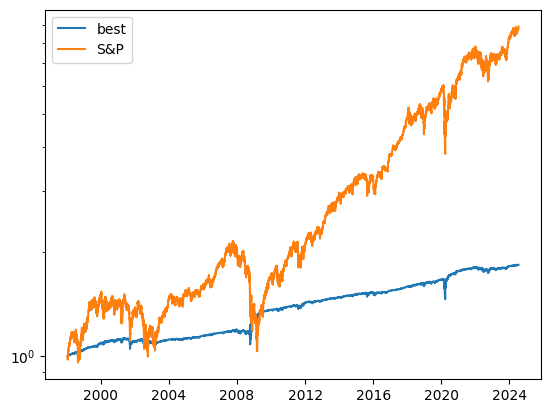

Round 2: 5.481186191361525
New best: 5.481186191361525
{'time_param': 104, 'method': 'ew', 't': 0.02730658176376166, 'k': 3.6940965795690253, 'as_q': True, 'transform_f': 'bounded_curve'}


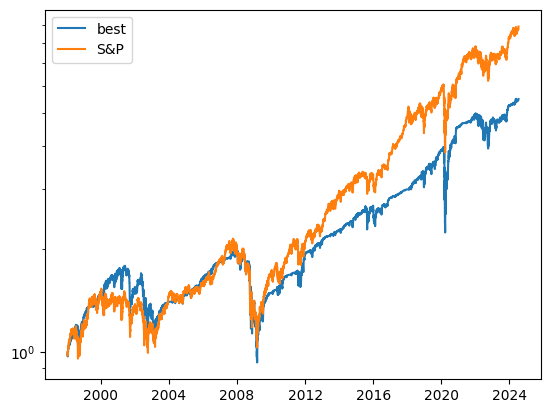

Round 3: 22.621359295032207
New best: 22.621359295032207
{'time_param': 247, 'method': 'linear', 't': 0.2445927546295963, 'k': 9.65720522706309, 'as_q': False, 'transform_f': 'bounded_curve'}


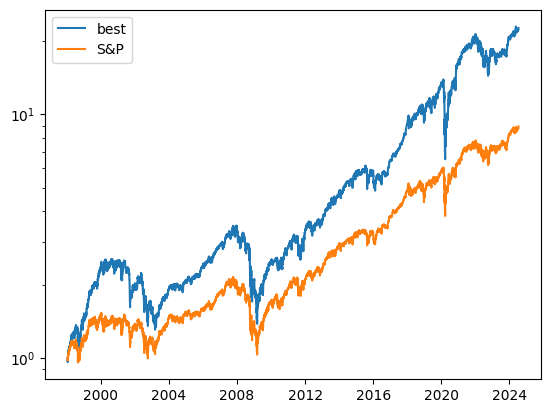

Round 4: 31.47125234670279
New best: 31.47125234670279
{'time_param': 77, 'method': 'ew', 't': 0.7651176538278237, 'k': 5.456993321914256, 'as_q': True, 'transform_f': 'bounded_curve'}


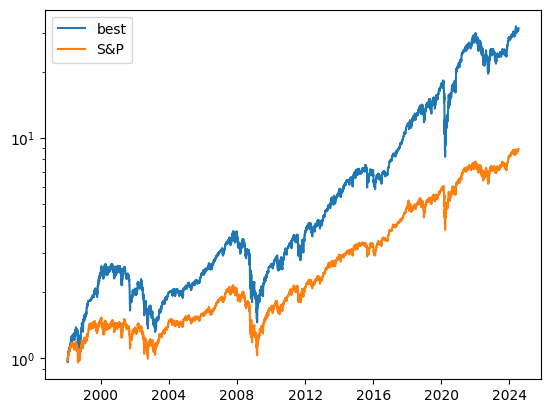

Round 5: 10.176131156168406
Round 6: nan
Round 7: nan
Round 8: 9.396336534796205
Round 9: 4.445143785805434
Round 10: 1.3624453656199864
Round 11: 7.563772560390934
Round 12: 5.62613743910331
Round 13: 17.47132949695162
Round 14: 4.41039393059067
Round 15: 5.042252052117934
Round 16: nan
Round 17: nan
Round 18: 1.0544239081308266
Round 19: 8.32369260777158
Round 20: 3.986774943387023
Round 21: 25.21492321920475
Round 22: 8.201459523964804
Round 23: 7.041705809258579
Round 24: 1.646741724804077
Round 25: nan
Round 26: 2.5350220400379113
Round 27: 6.6923475927123
Round 28: 2.5745131993393042
Round 29: 4.1168210428077
Round 30: nan
Round 31: 26.85214000857047
Round 32: nan
Round 33: 31.971118707957682
New best: 31.971118707957682
{'time_param': 135, 'method': 'linear', 't': 0.8322689873172803, 'k': 7.636060940460874, 'as_q': False, 'transform_f': 'bounded_curve'}


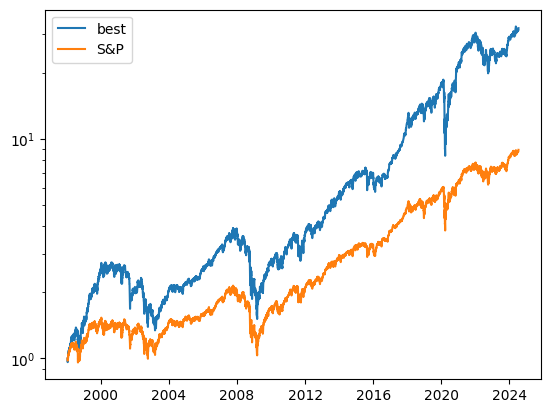

Round 34: 4.855940116043085
Round 35: nan
Round 36: nan
Round 37: nan
Round 38: 5.774582847520828
Round 39: nan
Round 40: nan
Round 41: nan
Round 42: nan
Round 43: 10.320343972808322
Round 44: nan
Round 45: 1.7422443536929377
Round 46: 23.944348961479797
Round 47: 31.894025048545416
Round 48: nan
Round 49: nan
Round 50: 6.503461541498649
Round 51: nan
Round 52: 13.138509361701342
Round 53: 2.7091065507815477
Round 54: nan
Round 55: 30.68702093519424
Round 56: nan
Round 57: 19.180745834555708
Round 58: nan
Round 59: 6.4345233137558395
Round 60: 9.158608982662628
Round 61: nan
Round 62: 11.74156476636309
Round 63: nan
Round 64: nan
Round 65: 26.79585582490204
Round 66: nan
Round 67: nan
Round 68: 16.350621758081957
Round 69: nan
Round 70: 1.3471078417365256
Round 71: nan
Round 72: nan
Round 73: 5.801215058236634
Round 74: 2.4255287320377983
Round 75: 4.486880106026915
Round 76: 1.9142309806006415
Round 77: 1.2159035020200362
Round 78: 33.55436395490332
New best: 33.55436395490332
{'time_

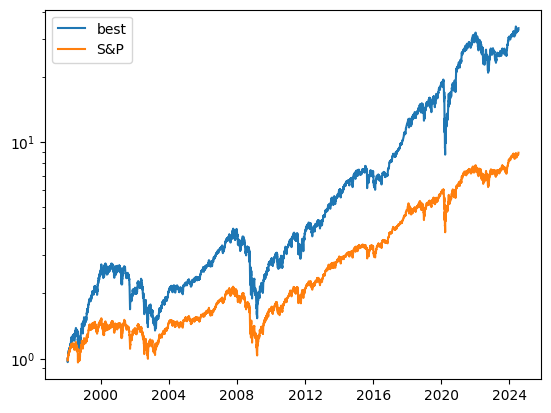

Round 79: nan
Round 80: nan
Round 81: nan
Round 82: 25.82724938891071
Round 83: 16.729488573761508
Round 84: 27.910286048286046
Round 85: nan
Round 86: 1.224822599953845
Round 87: 2.3390828615046395
Round 88: nan
Round 89: nan
Round 90: 4.55275251531288
Round 91: nan
Round 92: 3.571649997610817
Round 93: nan
Round 94: 26.003739223166953
Round 95: nan
Round 96: nan
Round 97: 7.148100652161556
Round 98: 5.924761455758944
Round 99: 6.631668801849207
Round 100: 16.75641504344007


In [58]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [80]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 8.921162322386886
Round 1: 32.822645393676254
Round 2: 26.22123751659737
Round 3: 7.160233285965072
Round 4: 32.875780851157835
Round 5: 17.55609725712895
Round 6: 32.898607412668156
Round 7: 32.86577302064987
Round 8: 32.885158688163074
Round 9: 8.394144254900159
Round 10: 32.90947081839916
Round 11: 9.981012567042669
Round 12: 6.83745143807039
Round 13: 6.594342506317527
Round 14: 33.1310877938996
Round 15: 32.975514592546254
Round 16: 15.934978706278724
Round 17: 32.93030978143078
Round 18: 8.695380583279178
Round 19: 6.653629703617681
Round 20: 32.945201887260566
Round 21: 10.362649074784915
Round 22: 29.93836311578307
Round 23: 22.53196354859162
Round 24: 33.084575210315855
Round 25: 8.000198981683166

Factor: 1.03125
Do nothing res: 8.921162322386886
Round 1: 17.603959529546476
Round 2: 27.37451448234131
Round 3: 32.92712316999757
Round 4: 33.05187299547005
Round 5: 8.855258804765104
Round 6: 11.389388874896515
Round 7: 32.946015120341336
Round 8: 7

In [81]:
# Force set:
#best_out = 33.55436395490332
#params_out = {'time_param': 153, 'method': 'ew', 't': 0.9977578507998721, 'k': 0.1502092583872895, 'as_q': True, 'transform_f': 'bounded_sigmoid'}

In [82]:
final_out = simulate(df, params_out)

In [83]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9999999998157479

In [84]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.6167817472230561

In [85]:
params_out

{'time_param': 153,
 'method': 'ew',
 't': 0.9977578507998721,
 'k': 0.1502092583872895,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)
/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: overflow encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


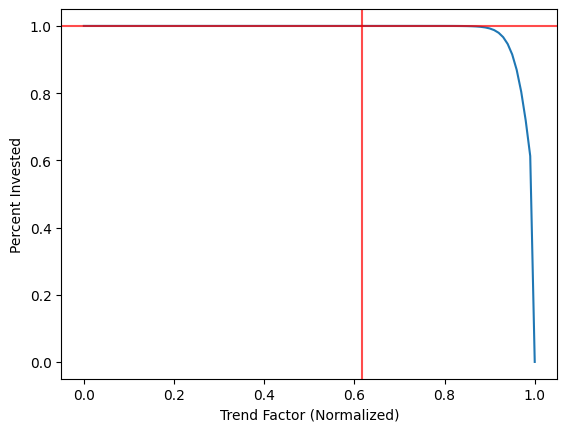

In [86]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

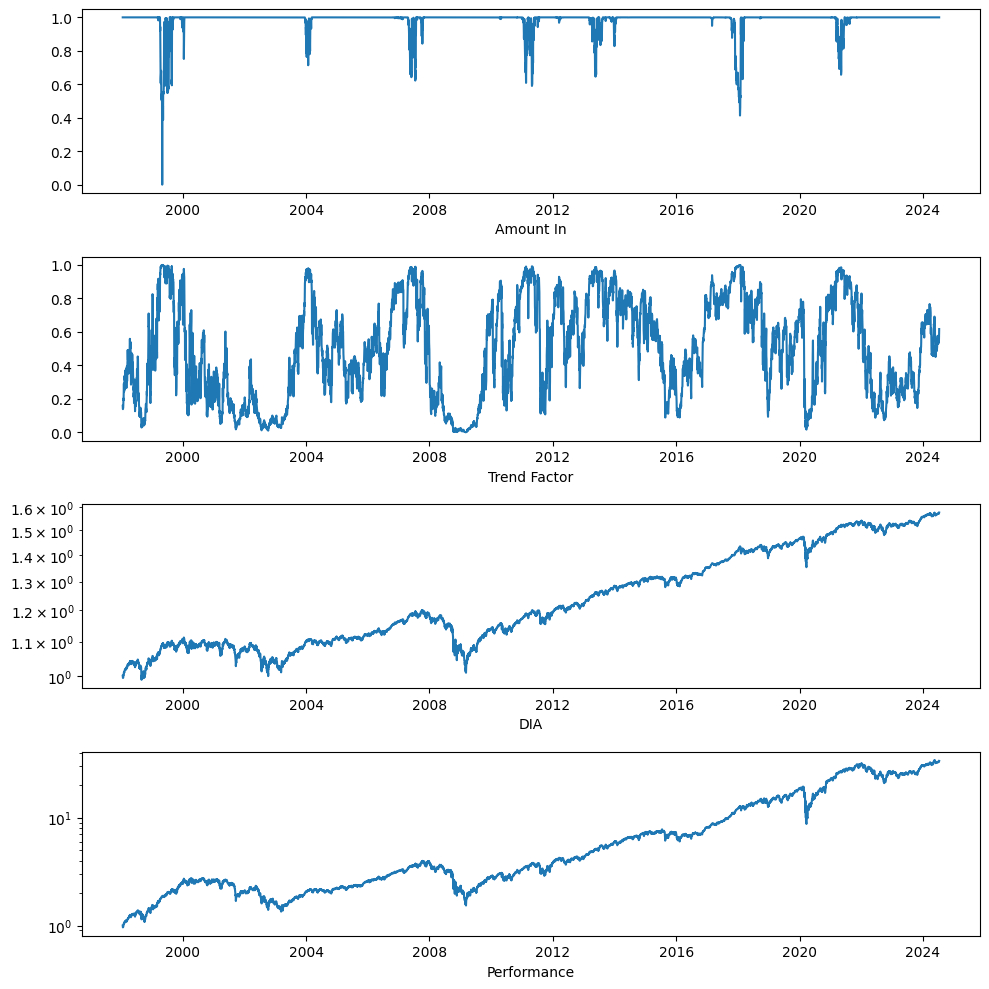

In [90]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [88]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('DIA')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

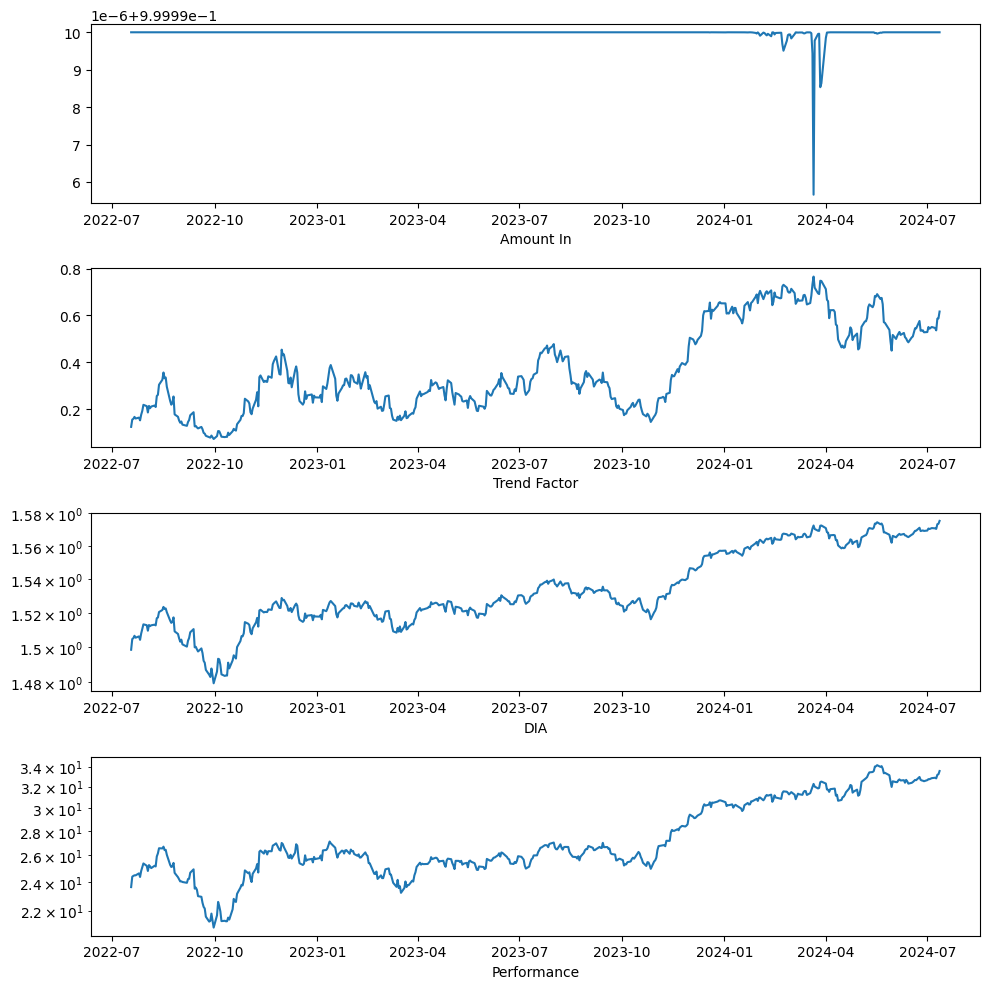

In [91]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [92]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(33.55436395490332,
 {'time_param': 153,
  'method': 'ew',
  't': 0.9977578507998721,
  'k': 0.1502092583872895,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

In [93]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [94]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(44.873077392578125, 26.652, 400.32000732421875)

In [95]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.14089866985628574

In [96]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['dia'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.117876849072677, 0.9707], 'nas': [1.221824877675853, 0.9613], 'rus': [1.1796414650730493, 0.6677], 'jpxn': [1.0475688418507474, 0.2309], 'ktec': [1.6341333973019867, 0.0], 'emb': [1.0930267520260304, 0.9993], 'gdx': [1.3608341604830252, 0.0174], 'dia': [1.1408986698562857, 1.0]}
